In [1]:
import random
import json
import numpy as np
import pandas as pd
from datetime import datetime

import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchvision.models._utils import IntermediateLayerGetter

from models.modeling.deeplab import *
from dataloader.talk2car import *

import denseCRF
import pydensecrf.densecrf as dcrf

from PIL import Image
from skimage.transform import resize

from losses import Loss
from models.model import JointModel

from utils.im_processing import *
from utils.metrics import *

# from summarizer import Summarizer

from collections import Counter
from nltk.corpus import stopwords

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

In [3]:
class Args:
    lr = 3e-4
    batch_size = 64
    num_workers = 4
    image_encoder = "deeplabv3_plus"
    num_layers = 1
    num_encoder_layers = 1
    dropout = 0.25
    skip_conn = False
    model_path = "./saved_model/talk2car/jrm_baseline_drop_0.25_bs_64_el_1_sl_40_bce_0.58126.pth"
    loss = "bce"
    dataroot = "/ssd_scratch/cvit/kanishk/"
    glove_path = "/ssd_scratch/cvit/kanishk/glove/"
    dataset = "talk2car"
    task = "talk2car"
    split = "val"
    seq_len = 40
    image_dim = 448
    mask_dim = 448
    mask_thresh = 0.3
    area_thresh = 0.4
    topk = 10
    metric = "pointing_game"

args = Args()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [5]:
print("Initializing dataset")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
resize = transforms.Resize((args.image_dim, args.image_dim))

train_dataset = Talk2Car(
    root=args.dataroot,
    split="train",
    transform=transforms.Compose([resize, to_tensor, normalize]),
    mask_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
    glove_path=args.glove_path
)

val_dataset = Talk2Car(
    root=args.dataroot,
    split="val",
    transform=transforms.Compose([resize, to_tensor, normalize]),
    mask_transform=transforms.Compose([ResizeAnnotation(args.mask_dim)]),
    glove_path=args.glove_path
)

# val_loader = DataLoader(
#     val_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True
# )

Initializing dataset


In [6]:
train_loader = DataLoader(
    train_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True
)

In [7]:
return_layers = {"layer2": "layer2", "layer3": "layer3", "layer4": "layer4"}

model = DeepLab(num_classes=21, backbone="resnet", output_stride=16)
model.load_state_dict(torch.load("./models/deeplab-resnet.pth.tar")["state_dict"])

image_encoder = IntermediateLayerGetter(model.backbone, return_layers)

for param in image_encoder.parameters():
    param.requires_grad_(False)

In [8]:
in_channels = 2048
out_channels = 512
stride = 2

joint_model = JointModel(
    in_channels=in_channels,
    out_channels=out_channels,
    stride=stride,
    num_layers=args.num_layers,
    num_encoder_layers=args.num_encoder_layers,
    dropout=args.dropout,
    skip_conn=args.skip_conn,
    mask_dim=args.mask_dim,
)

if n_gpu > 1:
    image_encoder = nn.DataParallel(image_encoder)
    joint_model = nn.DataParallel(joint_model)

state_dict = torch.load(args.model_path)
if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
joint_model.load_state_dict(state_dict) 

<All keys matched successfully>

In [9]:
joint_model.to(device)
image_encoder.to(device)

image_encoder.eval();
joint_model.eval();

In [10]:
loss_func = Loss(args)
val_iter = iter(val_loader)

In [11]:
def compute_mask_IOU(masks, target, thresh=0.3):
    assert(target.shape[-2:] == masks.shape[-2:])
    temp = ((masks>thresh) * target)
    intersection = temp.sum()
    union = (((masks>thresh) + target) - temp).sum()
    return intersection, union

def meanIOU(m, gt, t):
    temp = ((m > t)*gt)
    inter = temp.sum()
    union = ((m > t) + gt - temp).sum()
    return inter/union

In [16]:
data_len = val_dataset.__len__()

### Command Analysis

In [12]:
# train_commands = []
# val_commands = []

# train_count, val_count = 0, 0
# for batch in train_loader:
    
#     train_command = batch["orig_phrase"][0]
    
#     if len(train_command.split()) < 8:
#         train_count += 1
    
#     train_commands.append(train_command)

# for batch in val_loader:
    
#     val_command = batch["orig_phrase"][0]
    
#     if len(val_command.split()) < 8:
#         val_count += 1
        
#     val_commands.append(val_command)

In [13]:
# train_count, val_count

In [14]:
# train_avg_len = sum([len(command.split()) for command in train_commands])/len(train_commands)
# val_avg_len = sum([len(command.split()) for command in val_commands])/len(val_commands)

# print(train_avg_len, val_avg_len)

### Example Visualization

In [ ]:
val_iter = iter(val_loader)

In [ ]:
data_len = val_dataset.__len__()
# indx = random.choice(range(data_len))
# batch = val_dataset.__getitem__(indx)

In [ ]:
# indices = random.sample(range(data_len), 20)
indices = list(range(data_len))

In [ ]:
data_len

In [ ]:
# wrong_indices = [120, 106, 82, 212, 135, 227, 237, 58, 141, 165, 22, 307, 215, 129, 233, 75, 373, 336, 348, 347, 132, 4, 146, 241, 267, 343, 384, 79, 204, 296, 350, 352, 155, 272, 244, 217, 220, 43, 314, 181, 306, 20, 78, 297, 122, 137, 148, 372, 31, 208, 290, 60, 89, 256, 218, 221, 282, 168, 34, 349, 231, 281, 400, 17, 301, 205, 207, 203, 72, 88, 247, 54, 299, 269, 196, 300, 46, 442, 119, 70]

In [ ]:
# omitted_indices = random.choices(wrong_indices, k=30)

In [ ]:
# best_counter = Counter()
# with PdfPages(f'results_val_complex_{args.mask_thresh}.pdf') as pdf:
#     for indx in indices:

#         batch = val_dataset.__getitem__(indx)

#         img = batch["image"].cuda(non_blocking=True).unsqueeze(0)

#         # phrase = batch["phrase"].cuda(non_blocking=True)
#         # phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

#         ### Custom Phrase ###
#         # batch["orig_phrase"] = "park near the left car"
#         # batch["orig_phrase"] = summarizer(batch["orig_phrase"])
#         phrase, phrase_mask = val_dataset.vocabulary.tokenize(batch["orig_phrase"])
#         phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
#         phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

#         image_id = batch["index"].item()

#         gt_mask = batch["seg_mask"]
#         gt_mask = gt_mask.squeeze(dim=1)

#         orig_image = batch["orig_image"] #.numpy()
#         orig_phrase = batch["orig_phrase"]

#         batch_size = img.shape[0]
#         img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

#         # if len(orig_phrase.split()) > 5:
#         #     continue

#         with torch.no_grad():
#             img = image_encoder(img)  # ['out']

#         output_mask = joint_model(img, phrase, img_mask, phrase_mask)

#         output_mask = output_mask.detach().cpu().squeeze()
#         mask_out = output_mask[0]

#         max_index = output_mask.flatten(0).argmax(dim=-1) #[:, None]
#         mask_value = gt_mask.flatten(0)[max_index].item()

#         # if mask_value == 1:
#         #     continue

#         loss = loss_func(output_mask, gt_mask).item()
#         inter, union = compute_mask_IOU(output_mask, gt_mask)

#         score = inter / union

#         # orig_mask = batch["orig_mask"]

#         example = {
#             "image": orig_image,
#             "phrase": orig_phrase,
#             "mask_gt": gt_mask,
#             "mask_pred": output_mask,
#             # "orig_mask": orig_mask,
#         }

#         image = example["image"] #[0]
#         phrase = example["phrase"]
#         mask_gt = example["mask_gt"]#[0]
#         mask_pred = example["mask_pred"]#[0]

#     #     if image_id in omitted_indices:
#     #         continue

#     #     print(image_id, phrase)

#         ### Display Image ###
#         im = image

#         iou = []
#         thr = []
#         cum_sum = []

#         t_ = 0.0

#         best_t = t_
#         best_iou = 0

#         while t_ < 1:
#             miou = meanIOU(output_mask, gt_mask, t_)
#             cum_sum.append((output_mask > t_).sum())
#             iou.append(miou)
#             thr.append(t_)

#             if best_iou < miou:
#                 best_iou = miou
#                 best_t = t_

#             t_ += 0.05

#         if best_t == 0:
#             best_t += 0.0001

#         best_counter.update({best_t:1})

#         ## Prediction
#         im_seg = im[:] / 2
#         predicts = (mask_pred > args.mask_thresh).numpy()

#         ## Combined
#         im_comb = im[:] / 2

#         ## Ground Truth
#         im_gt = im[:] / 2
#         gt = (mask_gt > 0).numpy()

#         ## Prediction 
#         im_seg[:, :, 0] += predicts.astype('uint8') * 100
#         im_seg = im_seg.astype('uint8')

#         ## Best Threshold
#         im_comb[:, :, 0] += predicts.astype('uint8') * 100
#         im_comb[:, :, 1] += gt.astype('uint8') * 100
#         im_comb = im_comb.astype('uint8')

#         ## Ground Truth
#         im_gt[:, :, 1] += gt.astype('uint8') * 100
#         im_gt = im_gt.astype('uint8')


#         figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

#         axes[0, 0].imshow(im)
#         axes[0, 0].set_title(f"Image:: {image_id}", fontsize=20)
#         axes[0, 0].axis("off")

#         axes[0, 1].imshow(im_gt)
#         axes[0, 1].set_title("Ground Truth MAP", fontsize=20)
#         axes[0, 1].axis("off")

#         axes[1, 0].imshow(im_seg)
#         axes[1, 0].set_title(f"Predicted MAP (Threshold: {args.mask_thresh})", fontsize=20)
#         axes[1, 0].axis("off")

#         axes[1, 1].imshow(im_comb)
#         axes[1, 1].set_title(f"Combined (predicted + ground_truth)", fontsize=20)
#         axes[1, 1].axis("off")

#         figure.suptitle(f"{phrase}", y=0.51, fontsize=25)

#         # plt.show()

#         pdf.savefig(figure)

#         plt.cla()
#         plt.clf()
#         plt.close()


### Index Specific Predictions

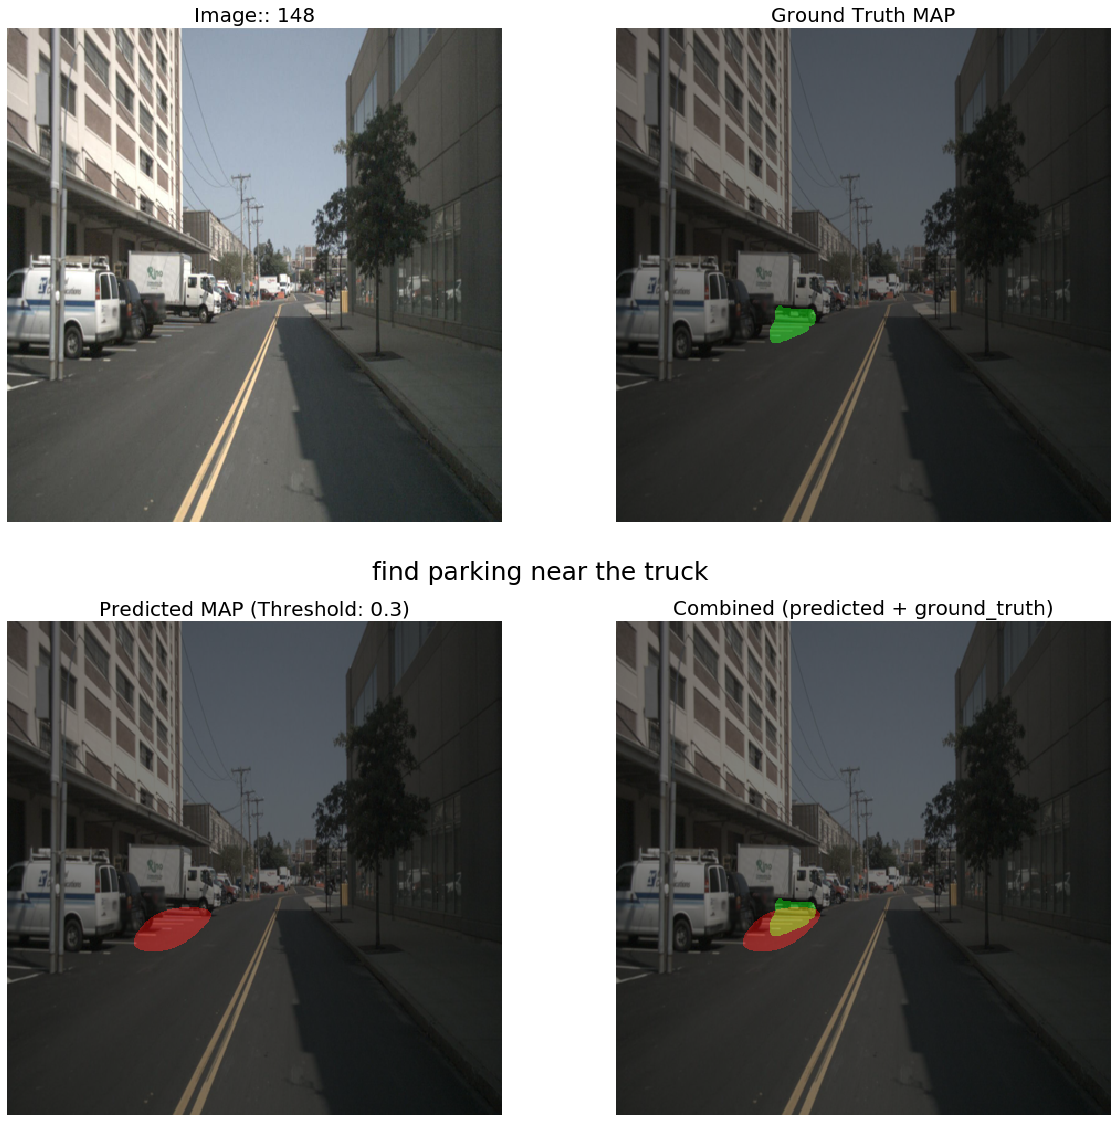

In [18]:
indx = random.choice(range(data_len))
batch = val_dataset.__getitem__(indx)

img = batch["image"].cuda(non_blocking=True).unsqueeze(0)

# phrase = batch["phrase"].cuda(non_blocking=True)
# phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)

### Custom Phrase ###
# batch["orig_phrase"] = "take a right turn"
# batch["orig_phrase"] = summarizer(batch["orig_phrase"])
phrase, phrase_mask = val_dataset.vocabulary.tokenize(batch["orig_phrase"])
phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

gt_mask = batch["seg_mask"]
gt_mask = gt_mask.squeeze(dim=1)

orig_image = batch["orig_image"] #.numpy()
orig_phrase = batch["orig_phrase"]

batch_size = img.shape[0]
img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

# if len(orig_phrase.split()) > 5:
#     continue

with torch.no_grad():
    img = image_encoder(img)  # ['out']

output_mask = joint_model(img, phrase, img_mask, phrase_mask)

output_mask = output_mask.detach().cpu().squeeze()
mask_out = output_mask[0]

max_index = output_mask.flatten(0).argmax(dim=-1) #[:, None]
mask_value = gt_mask.flatten(0)[max_index].item()

loss = loss_func(output_mask, gt_mask).item()
inter, union = compute_mask_IOU(output_mask, gt_mask)

score = inter / union

# orig_mask = batch["orig_mask"]

example = {
    "image": orig_image,
    "phrase": orig_phrase,
    "mask_gt": gt_mask,
    "mask_pred": output_mask,
    # "orig_mask": orig_mask,
}

image = example["image"] #[0]
phrase = example["phrase"]
mask_gt = example["mask_gt"]#[0]
mask_pred = example["mask_pred"]#[0]

# im = (image * 255).astype('uint8')
im = image

iou = []
thr = []
cum_sum = []

t_ = 0.0

best_t = t_
best_iou = 0

while t_ < 1:
    miou = meanIOU(output_mask, gt_mask, t_)
    cum_sum.append((output_mask > t_).sum())
    iou.append(miou)
    thr.append(t_)

    if best_iou < miou:
        best_iou = miou
        best_t = t_

    t_ += 0.05

if best_t == 0:
    best_t += 0.0001

# best_counter.update({best_t:1})

## Prediction
im_seg = im[:] / 2
predicts = (mask_pred > args.mask_thresh).numpy()

## Combined
im_comb = im[:] / 2

## Ground Truth
im_gt = im[:] / 2
gt = (mask_gt > 0).numpy()

## Prediction 
im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

## Best Threshold
im_comb[:, :, 0] += predicts.astype('uint8') * 100
im_comb[:, :, 1] += gt.astype('uint8') * 100
im_comb = im_comb.astype('uint8')

## Ground Truth
im_gt[:, :, 1] += gt.astype('uint8') * 100
im_gt = im_gt.astype('uint8')


figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0, 0].imshow(im)
axes[0, 0].set_title(f"Image:: {indx}", fontsize=20)
axes[0, 0].axis("off")

axes[0, 1].imshow(im_gt)
axes[0, 1].set_title("Ground Truth MAP", fontsize=20)
axes[0, 1].axis("off")

axes[1, 0].imshow(im_seg)
axes[1, 0].set_title(f"Predicted MAP (Threshold: {args.mask_thresh})", fontsize=20)
axes[1, 0].axis("off")

axes[1, 1].imshow(im_comb)
axes[1, 1].set_title(f"Combined (predicted + ground_truth)", fontsize=20)
axes[1, 1].axis("off")

figure.suptitle(f"{phrase}", y=0.51, fontsize=25)

plt.show()

### Command Analysis

In [31]:
args.split = "val"
with open("/home/kanishk/vigil/autonomous_grounding/dataloader/talk2car_w_rpn_no_duplicates.json", "rb") as f:
    data = json.load(f)[args.split]
    data = {int(k): v for k, v in data.items()}
img_dir = os.path.join(args.dataroot, "imgs")
mask_dir = os.path.join(args.dataroot, "mask_image_bin")

data_len = len(data)
print(f'Total Examples in {args.split} set: {data_len}')

Total Examples in val set: 1163


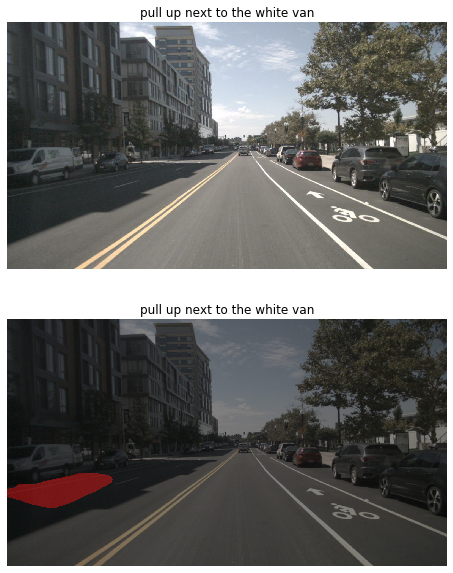

In [32]:
index = random.choice(range(data_len))
command = data[index]['command']

img_file = data[index]['img']
img_path = os.path.join(img_dir, img_file)

mask_file = f"gt_img_ann_{args.split}_{index}.png"
mask_path = os.path.join(mask_dir, mask_file)

img = Image.open(img_path)
img = np.array(img)

mask = Image.open(mask_path)
mask = np.array(mask)

img_overlay = img[:] / 2
mask_ = (mask > 0)
img_overlay[:, :, 0] += mask_.astype('uint8') * 100
img_overlay = img_overlay.astype('uint8')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].imshow(img)
ax[0].set_title(command)
ax[0].set_axis_off()

ax[1].imshow(img_overlay)
ax[1].set_title(command)
ax[1].set_axis_off()

plt.show()

In [ ]:
# simple_command = summarizer(command)

In [41]:
# keywords = ["stop", "slow", "wait", "then", "speed", "change", "continue", "follow", "u-turn", "once"]
keywords = ["stop", "slow", "wait", "park", "speed", "change", "turn", "follow", "u-turn", "straight", "pull", "switch"]

In [42]:
def intersection(command):
    count = 0
    words = []
    for key in keywords:
        if key in command:
            words.append(key)
            count += 1
    return count, words

In [44]:
stop_words = set(stopwords.words('english'))

counter = Counter()

count_ = 0

for ind in data:
    command = data[ind]['command']
    
#     command_len = len(command.split())
    
    count, words = intersection(command)
    
    if count == 0:
        print(command)
        count_ += 1
    
#     if "continue" in command:
#         # print(command)
#         count += 1
        
    for word in command.split():
        if word not in stop_words:
            counter.update({word:1})
print(count_)

let me out behind that first car in the sun
pass this vehicle when it is safe to do so.
go the same direction as the dark red car in front of you. 
oh no, look ahead of you. someones car broke down. proceed carefully. 
move a little to the left to give some space to the black car on the right.
pass this car and take the next right
pick up jim who is standing by the tree. 
drive in the right lane and get behind that bus up ahead.
wow hold on! that looks like my stolen bike over there! drop me off next to it.
move into the right hand lane to let the car on the left out
go to the right lane after you have passed the truck
continue driving in the lane next to the truck.
after this guy pushing the barrier has crossed let us continue. i'm in a hurry.
do not proceed until this worker has cleared the intersection
open the sunroof after passing this truck
hi car, my colleague is just right in front of us. let me out near him then i can start my shift. thanks a lot!
move to the left near the whi

In [ ]:
#### Training Dataset ####
#  0-5  :  362
#  5-10 : 3011
# 10-15 : 2204
# 15-20 :  815
# 20-25 :  231
# 25-   :   72

In [ ]:
df = pd.DataFrame.from_dict(dict(counter), orient='index', columns=['frequency'])
df.index.name = 'word'

df.sort_values('frequency', ascending=False)[:50]

In [ ]:
print(counter, sum(counter.values()))

### Evaluation Metrics

In [ ]:
updated_sen = []
with open('/home/kanishk/vigil/autonomous_grounding/dataloader/updated_annotation_sentences.txt', 'r') as f:
    for line in f.readlines():
        updated_sen.append(line.strip())

In [19]:
keywords = ["stop", "slow", "wait", "then", "speed", "change", "continue", "follow", "u-turn", "once"]

def intersection(command):
    count = 0
    words = []
    for key in keywords:
        if key in command:
            words.append(key)
            count += 1
    return count, words

In [20]:
print("Temporal Keywords")
print(keywords)

Temporal Keywords
['stop', 'slow', 'wait', 'then', 'speed', 'change', 'continue', 'follow', 'u-turn', 'once']


In [21]:
@torch.no_grad()
def pointing_game_(masks, target):
    assert target.shape[-2:] == masks.shape[-2:]
    batch_size = masks.shape[0]
    max_indices = masks.flatten(1).argmax(dim=-1)[:, None]
    accuracy = target.flatten(1).gather(1, max_indices).mean().item()
    return accuracy

In [25]:
data_len

1163

In [64]:
args.metric = "recall_at_k"
args.topk = 200

args.mask_thresh = 0.3

image_encoder.eval()
joint_model.eval()

total_inter = 0
total_union = 0

total_accuracy = 0

# result_map = {
#     '0-5': {},
#     '5-10': {},
#     '10-15': {},
#     '15-20': {},
#     '20-25': {},
#     '25-': {}
# }

result_map = {
    '0-10': {},
    '10-20': {},
    '20-': {},
}

area_thresh = args.metric

# result_map = {
#     'non-temporal': {},
#     'temporal': {},
# }

# result_map = {}

# result_map = {key: {} for key in keywords}

mean_IOU = 0
total_accuracy = 0

prec_at_x = {0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}

data_len = len(val_loader)

n_iter = 0

base_correct = 0

for step, batch in enumerate(val_loader):

    img = batch["image"].cuda(non_blocking=True)

    phrase = batch["phrase"].cuda(non_blocking=True)
    phrase_mask = batch["phrase_mask"].cuda(non_blocking=True)
    index = batch["index"]
    
#     if index.item() < 101:
#         batch["orig_phrase"] = updated_sen[index.item()]
#         phrase, phrase_mask = val_dataset.vocabulary.tokenize(batch["orig_phrase"])
#         phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
#         phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)
        

    gt_mask = batch["seg_mask"]
    gt_mask = gt_mask.squeeze(dim=1)
    
    _, h, w = gt_mask.shape
    
    if gt_mask[0, w//2, h//2] > 0:
        base_correct += 1

    batch_size = img.shape[0]
    img_mask = torch.ones(batch_size, 14 * 14, dtype=torch.int64).cuda(
        non_blocking=True
    )
    
    orig_phrase = batch["orig_phrase"][0]
    phrase_len = len(orig_phrase.split())
    
    with torch.no_grad():
        img = image_encoder(img)

    output_mask = joint_model(img, phrase, img_mask, phrase_mask)
    output_mask = output_mask.detach().cpu()
    
    count, inter_words = intersection(orig_phrase)
    
    # if count not in result_map:
    #     result_map[count] = {}
    
    # if count == 0:
    #     continue
    
    # for area_thresh in [0.1, 0.2, 0.3, 0.4, 0.5]:

    inter, union = compute_batch_IOU(output_mask, gt_mask, args.mask_thresh)

    total_inter += inter.sum().item()
    total_union += union.sum().item()
    
#     for area_thresh in [0.1, 0.2, 0.3, 0.4, 0.5]:

    accuracy = 0
    if args.metric == "pointing_game":
        accuracy += pointing_game(output_mask, gt_mask)
    elif args.metric == "intersection_at_t":
        accuracy += intersection_at_t(output_mask, gt_mask, args.mask_thresh, area_thresh)
    elif args.metric == "recall_at_k":
        accuracy += recall_at_k(output_mask, gt_mask, args.topk)
    elif args.metric == "dice_score":
        accuracy += dice_score(output_mask, gt_mask, args.mask_thresh)
    total_accuracy += accuracy

    # ############## PHRASE LEN ANALYSIS ###############
    # if phrase_len < 5:
    #     if area_thresh not in result_map['0-5']:
    #         result_map['0-5'][area_thresh] = []
    #     result_map['0-5'][area_thresh].append(accuracy)
    # elif phrase_len < 10:
    #     if area_thresh not in result_map['5-10']:
    #         result_map['5-10'][area_thresh] = []
    #     result_map['5-10'][area_thresh].append(accuracy)
    # elif phrase_len < 15:
    #     if area_thresh not in result_map['10-15']:
    #         result_map['10-15'][area_thresh] = []
    #     result_map['10-15'][area_thresh].append(accuracy)
    # elif phrase_len < 20:
    #     if area_thresh not in result_map['15-20']:
    #         result_map['15-20'][area_thresh] = []
    #     result_map['15-20'][area_thresh].append(accuracy)
    # elif phrase_len < 25:
    #     if area_thresh not in result_map['20-25']:
    #         result_map['20-25'][area_thresh] = []
    #     result_map['20-25'][area_thresh].append(accuracy)
    # else:
    #     if area_thresh not in result_map['25-']:
    #         result_map['25-'][area_thresh] = []
    #     result_map['25-'][area_thresh].append(accuracy)
    # ####################################################

    ############## PHRASE LEN ANALYSIS (10 gap) ###############
    if phrase_len < 10:
        if area_thresh not in result_map['0-10']:
            result_map['0-10'][area_thresh] = []
        result_map['0-10'][area_thresh].append(accuracy)
    elif phrase_len < 20:
        if area_thresh not in result_map['10-20']:
            result_map['10-20'][area_thresh] = []
        result_map['10-20'][area_thresh].append(accuracy)
    else:
        if area_thresh not in result_map['20-']:
            result_map['20-'][area_thresh] = []
        result_map['20-'][area_thresh].append(accuracy)
    ####################################################

    # ############ TEMPORAL WORD COUNT #################
    # if area_thresh not in result_map[count]:
    #     result_map[count][area_thresh] = []
    # result_map[count][area_thresh].append(accuracy)
    # ##################################################

    # ############ TEMPORAL WORDs #################
    # for word in inter_words:
    #     if area_thresh not in result_map[word]:
    #         result_map[word][area_thresh] = []
    #     result_map[word][area_thresh].append(accuracy)
    # ##################################################

    # ################### TEMPORAL LENGTH ######################
    # if count > 0:
    #     if area_thresh not in result_map['temporal']:
    #         result_map['temporal'][area_thresh] = []
    #     result_map['temporal'][area_thresh].append(accuracy)
    # else:
    #     if area_thresh not in result_map['non-temporal']:
    #         result_map['non-temporal'][area_thresh] = []
    #     result_map['non-temporal'][area_thresh].append(accuracy)
    # ############################################################

    score = 0 if union.item() == 0 else inter.item() / union.item()

    mean_IOU += score

    total_score = total_inter / total_union

    for x in prec_at_x:
        if score > x:
            prec_at_x[x] += 1

overall_IOU = total_inter / total_union
mean_IOU = mean_IOU / data_len
final_accuracy = total_accuracy / data_len

center_accuracy = base_correct / data_len
# print(f'Center Accuracy: {center_accuracy}')
print(args.metric)
print(f"Accuracy:{final_accuracy}, Overall_IOU: {overall_IOU}, Mean_IOU: {mean_IOU}, Total: {n_iter}, ")

for x in prec_at_x:
    percent = (prec_at_x[x] / data_len) * 100
    print(f"{x}% IOU: {percent}%")

print("==================================")

recall_at_k
Accuracy:0.6732588134135855, Overall_IOU: 0.22116938282647347, Mean_IOU: 0.21273426174844387, Total: 0, 
0.5% IOU: 13.757523645743767%
0.6% IOU: 6.190885640584694%
0.7% IOU: 1.8916595012897677%
0.8% IOU: 0.08598452278589853%
0.9% IOU: 0.0%


In [65]:
### Short Vs Long Phrases AND Temporal Vs Non-Temporal
print(f'Results at mask_thresh: {args.mask_thresh}')

refined_map = {}
for key1 in result_map:
    refined_map[key1] = {}
    total_len = 0
    for key2 in result_map[key1]:
        total_len += len(result_map[key1][key2])
        accuracy = torch.tensor(result_map[key1][key2])
        refined_map[key1][f'{key2}={args.topk}'] = accuracy.mean().item()
    refined_map[key1]['count'] = total_len // len(result_map[key1])

df_result = pd.DataFrame.from_dict(refined_map,orient='index')
df_result.index.name = 'phrase len'

df_result

Results at mask_thresh: 0.3


,recall_at_k=200,count
phrase len,,
0-10,0.694611,501
10-20,0.664395,587
20-,0.600000,75


In [ ]:
# 31 + 470 + 425 + 162 + 56 + 19
# 711 + 452

In [ ]:
### Sentences [0, 5] (Total 31)

# Threshold | Inters@0.5 | Inter@0.4 | Inter@0.3 | Inter@0.2 | Inter@0.1 | Overall IOU | Mean IOU |
#     0.3   |    32.22   |    38.70  |    41.93  |    48.38  |    54.83  |     24.82   |   17.02  |


### Sentences [5, 10] (Total 422)

# Threshold | Inters@0.5 | Inter@0.4 | Inter@0.3 | Inter@0.2 | Inter@0.1 | Overall IOU | Mean IOU |
#     0.3   |    41.94   |    47.86  |    53.55  |    58.76  |    63.74  |     23.51   |   23.71  |

### Sentences [10, 15] (Total ---)

# Threshold | Inters@0.5 | Inter@0.4 | Inter@0.3 | Inter@0.2 | Inter@0.1 | Overall IOU | Mean IOU |
#     0.3   |    --.--   |    --.--  |    --.--  |    --.--  |    --.--  |     --.--   |   --.--  |